<a href="https://colab.research.google.com/github/DataMinati/Super-Notebooks-100/blob/main/Chess_Piece_Detection_(Using_Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necessary Libraries

### Data Source : https://www.kaggle.com/taranmarley/squeezenet-transfer-learning/data

In [ ]:
import numpy as np
import pandas as pd 
import torch
from torch import optim
import torch.nn as nn
from PIL import Image
import os

# Create dataframe with class ids and filenames

In [ ]:
class_ids = ["KnightImages", "PawnImages", "Queenimages", "RookImage", "bishopImages"]

y = []
X = []
filenames = []
for class_id in class_ids:
    for file in os.listdir(os.path.join("../input/chess-pieces-detection-images-dataset", class_id)):
        X.append(os.path.join("../input/chess-pieces-detection-images-dataset", class_id, file))
        y.append(class_id)
        filenames.append(file)
        
df = pd.DataFrame(list(zip(X, filenames, y)), columns =['fileloc', 'filename', 'classid'])
df["int_class_id"] = df["classid"].astype("category").cat.codes
print(df.head())

                                             fileloc      filename  \
0  ../input/chess-pieces-detection-images-dataset...  00000030.jpg   
1  ../input/chess-pieces-detection-images-dataset...  00000042.jpg   
2  ../input/chess-pieces-detection-images-dataset...  00000027.jpg   
3  ../input/chess-pieces-detection-images-dataset...  00000127.jpg   
4  ../input/chess-pieces-detection-images-dataset...  00000113.jpg   

        classid  int_class_id  
0  KnightImages             0  
1  KnightImages             0  
2  KnightImages             0  
3  KnightImages             0  
4  KnightImages             0  


# Create the Custom Dataset Class

We need this to be able to load the image and label into the model we will create. So we will create a custom dataset to handle this

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, X, y, BatchSize, transform):
    super().__init__()
    self.BatchSize = BatchSize
    self.y = y
    self.X = X
    self.transform = transform
    
  def num_of_batches(self):
    """
    Detect the total number of batches
    """
    return math.floor(len(self.list_IDs) / self.BatchSize)

  def __getitem__(self,idx):
    class_id = self.y[idx]
    img = Image.open(self.X[idx])
    img = img.convert("RGBA").convert("RGB")
    img = self.transform(img)
    return img, torch.tensor(int(class_id))

  def __len__(self):
    return len(self.X)

# Instantiate the Datasets

We will form them into torch dataloaders to make the data easier to work with. We are also going to put in a minor amount of image augmentation in the train dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Shuffle dataframe
df = df.sample(frac=1)

X = df.iloc[:,0]
y = df.iloc[:,3]

transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.RandomRotation(20, fill=256),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
                transforms.ToTensor(),
                transforms.RandomAffine(degrees=0, translate=(0.025, 0.025), fill=256),
                transforms.Normalize([0.5], [0.5])
            ])

test_transform = transforms.Compose([
                transforms.Resize([256,256]),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])

train_ratio = 0.90
validation_ratio = 0.05
test_ratio = 0.05

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, stratify = y, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 0)

dataset_stages = ['train', 'val', 'test']

batch_size = 32
image_datasets = {'train' : CustomDataset(X_train.values, y_train.values, batch_size, transform), 'val' : CustomDataset(X_val.values, y_val.values, batch_size, test_transform), 'test' : CustomDataset(X_test.values, y_test.values, batch_size, test_transform)}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=image_datasets[x].BatchSize,
                                            shuffle=True, num_workers=0)
            for x in dataset_stages}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Test image from dataset

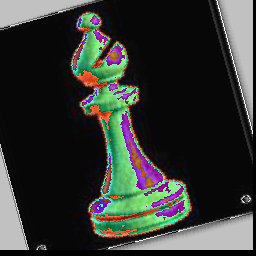

In [ ]:
nparray = image_datasets['train'][2][0].cpu().numpy() 
image = transforms.ToPILImage()(image_datasets['train'][2][0].cpu()).convert("RGB")
display(image)

In [ ]:
""" for i in range(0,10000):
    print(i)
    nparray = image_datasets['train'][i][0].cpu().numpy() 
    image = transforms.ToPILImage()(image_datasets['train'][i][0].cpu()).convert("RGB")
"""

' for i in range(0,10000):\n    print(i)\n    nparray = image_datasets[\'train\'][i][0].cpu().numpy() \n    image = transforms.ToPILImage()(image_datasets[\'train\'][i][0].cpu()).convert("RGB")\n'

# Create a Training Function

In [ ]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            num_batches = 0
            outputs = None
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # Loading Bar
                if (phase == 'train'):
                    num_batches += 1
                    percentage_complete = ((num_batches * batch_size) / (dataset_sizes[phase])) * 100
                    percentage_complete = np.clip(percentage_complete, 0, 100)
                    print("{:0.2f}".format(percentage_complete), "% complete", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.float(), labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # TODO: try removal
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                predicted = torch.max(outputs.data, 1)[1] 
                running_correct = (predicted == labels).sum()
                running_corrects += running_correct
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            
            epoch_acc = running_corrects / dataset_sizes[phase]
            #epoch_acc = sum(epoch_acc) / len(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc.item()))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

# Load up EfficientNet

In [ ]:
from torchvision import models
from torch.optim import lr_scheduler

In [ ]:

model_ft = models.squeezenet1_1(pretrained=True)
model_ft.classifier._modules["1"] = nn.Conv2d(512, 5, kernel_size=(1, 1))
model_ft.num_classes = 5
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft.to(device), criterion, optimizer_ft, exp_lr_scheduler, 20)

Epoch 0/19
----------
train Loss: 41.5943 Acc: 0.1931
val Loss: 1.5862 Acc: 0.2647
Epoch 1/19
----------
train Loss: 2.7518 Acc: 0.2162
val Loss: 1.5049 Acc: 0.3529
Epoch 2/19
----------
train Loss: 1.5611 Acc: 0.2690
val Loss: 1.6659 Acc: 0.3235
Epoch 3/19
----------
train Loss: 1.5326 Acc: 0.3036
val Loss: 1.4445 Acc: 0.4412
Epoch 4/19
----------
train Loss: 1.4503 Acc: 0.3498
val Loss: 1.3500 Acc: 0.4706
Epoch 5/19
----------
train Loss: 1.3804 Acc: 0.3960
val Loss: 1.3192 Acc: 0.5294
Epoch 6/19
----------
train Loss: 1.3482 Acc: 0.4373
val Loss: 1.0904 Acc: 0.6765
Epoch 7/19
----------
train Loss: 1.2335 Acc: 0.4818
val Loss: 1.0232 Acc: 0.7941
Epoch 8/19
----------
train Loss: 1.2148 Acc: 0.5017
val Loss: 0.9298 Acc: 0.7647
Epoch 9/19
----------
train Loss: 1.1897 Acc: 0.5281
val Loss: 0.8764 Acc: 0.7647
Epoch 10/19
----------
train Loss: 1.1884 Acc: 0.5050
val Loss: 0.8663 Acc: 0.7647
Epoch 11/19
----------
train Loss: 1.1708 Acc: 0.5462
val Loss: 0.8612 Acc: 0.7941
Epoch 12/19
-

# Run on Test Set

In [ ]:
from sklearn.metrics import accuracy_score 

accuracy_scores = []

running_corrects = 0
outputs = None
for inputs, labels in dataloaders['test']:
    model_ft.eval()
    
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model_ft(inputs)
    
    predicted = torch.max(outputs.data, 1)[1] 
    running_correct = (predicted == labels).sum()
    running_corrects += running_correct

accuracy = running_corrects / dataset_sizes['test']
print("Accuracy: " + str(accuracy.item()))

Accuracy: 0.529411792755127
